In [1]:
pip install doubleml

  Using cached DoubleML-0.4.1-py3-none-any.whl (116 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from scipy import stats
from scipy.stats import bernoulli
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from scipy.special import expit

In [ ]:
def gen_features_bernY(n_samples,n_features, trt_effect,treatment_prob, distribution, noise,seed):
    """
    Function to generate synthetic bernoulli outputs.
    
    
    By adding noise, you increase the probability for the output bit to be flipped
    """
    if distribution == 'gaussian':
        X = np.random.randn(n_samples, n_features)
        D =  bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X)) #
        weights = np.append(trt_effect,stats.norm.rvs(0, 1, size = n_features))
        
        #squeeze through logisitc sigmoid function
        Y =  expit(np.dot(dx,weights.T))
        #convert into binary outcomes
        Y = np.where(Y > 0.5, 1, 0)
        #add small prob to flip bit
        if noise > 0.0:
            flip_prob = noise
            flip_mask = np.array(np.random.choice([0,1], p=[1-flip_prob, flip_prob], size = Y.shape))  #80       
            Y_flipped = abs(Y - flip_mask)  

    elif distribution == 'bernoulli':
        # generate X features
        p_vec = np.random.uniform(size = int(n_features))
        X = stats.bernoulli.rvs(p = p_vec, size = [n_samples,int(n_features)])
        
        #add the treatment var into X data        
        D = bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X))
        #generate weights
        weights = np.append(trt_effect,stats.norm.rvs(0, 1, size = int(n_features)))
        Y = expit(np.dot(dx,weights.T))
        Y = np.where(Y > 0.5, 1, 0)
        
        #implement noise for bernoulli with noise = p(flip bit)
        if noise >0.0:
            flip_prob = noise
            flip_mask = np.array(np.random.choice([0,1], p=[1-flip_prob, flip_prob], size = Y.shape))  #80       
            Y_flipped = abs(Y - flip_mask)              
    else:
        print("Not a valid distribution")
    
    return X,dx,weights, Y, D,flip_mask, Y_flipped

In [ ]:
trt_effect = 0.5 #float
num_runs = [1,2,3] #array of integers
data_distribution = ["bernoulli","gaussian"] #gaussian/bernoulli
num_samples = 10 #array of integers
num_feats = 10 #array of integers
noises = 0.1 #
trt_prob = 0.9
seed = 123
X,dx, weights,Y,D, flip, yflipped = gen_features_bernY(n_samples=num_samples,
                                                       n_features=num_feats,trt_effect=trt_effect,
                                                       treatment_prob=trt_prob,distribution='gaussian',
                                                       noise=noises, seed=seed)

Below we can see the effect of the flipping of the outcome. The "Y" variable holds the original calculated Y, "flip" contains the binary switch of which digit will be flipped and finally "yflipped" contains the final outcome which is the abs(Y - flip).

In [ ]:
Y, flip, yflipped

In [ ]:
#define simulation parameters
trt_effect = 0.5 #float
num_runs = [1,2,3] #array of integers
data_distribution = ["bernoulli","gaussian"] #gaussian/bernoulli
num_samples = [1000000] #array of integers
num_feats = [10] #array of integers
noises = [0.1] #array of floats. normally distributed noise centered around 0. This value changes the std
trt_prob = [0.9]
seed = 123

#create empty df to hold 
df = pd.DataFrame(columns=['Run', 'OLS','OLS_LB','OLS_UB','std_err','DML','DML_err', 'DML_LB','DML_UB','DML_t_stat','num_samples','distribution','num_features','noise'])

############################
#### Execute simulation ####
############################
for run in num_runs:
    for feature_num in num_feats:
        for samples in num_samples:
            for dist in data_distribution:
                for noise in noises:
                #generate data
                    X,dx, weights,_,D, _, Y = gen_features_bernY(n_samples=samples,n_features=feature_num,trt_effect=trt_effect,treatment_prob=trt_prob,distribution=dist,noise=noise, seed=seed)
                    ######################################################################    
                    # OLS --------------------------------------------------     
                    ######################################################################
                    OLS = sm.OLS(Y,dx)
                    results = OLS.fit()        
                    
                    ####
                    ##Add confidence interval for OLS
                    ols_LB = results.conf_int(alpha=0.05, cols=None)[0][0]
                    ols_UB = results.conf_int(alpha=0.05, cols=None)[0][1]            
                    std_err = results.bse[0]
                    
                    ######################################################################
                    # DML package                      -----------------------------------     
                    ######################################################################
                    # DML ml_m_rf as classifier        -----------------------------------     
                    ######################################################################
                    dml_data = DoubleMLData.from_arrays(X, Y, D)
                    
                    ml_g_rf = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs = -1)
                    ml_m_rf = RandomForestClassifier(n_estimators=100,max_depth=10, n_jobs = -1)
                    
                    dml_plr_tree = DoubleMLPLR(dml_data, ml_g = ml_g_rf, ml_m = ml_m_rf)
                    #estimation
                    dml_plr_tree.fit()

                    row = [run,results.params[0],ols_LB,ols_UB,std_err, dml_plr_tree.coef,dml_plr_tree.se, dml_plr_tree.confint().iloc[0][0],dml_plr_tree.confint().iloc[0][1],dml_plr_tree.t_stat, samples, dist, feature_num, noise]
                    df.loc[len(df)] = row

In [ ]:
df[['DML','DML_err','DML_t_stat']] = df[['DML','DML_err','DML_t_stat']].apply(lambda x: x.str[0])

In [ ]:
df

This seems to throw OLS and DoubleML off, although OLS does perform better. DML does not get close to the prediction

In [ ]:
X[:1]

In [ ]:
Y[:1]

In [ ]:
D[:1]

In [ ]:
dml_plr_tree.summary

Text(0.5, 1.0, '1M samples, 10 features, bernoulli Y')

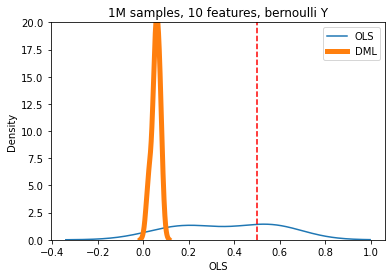

In [144]:
sns.kdeplot(df.OLS, label = 'OLS')
sns.kdeplot(df.DML, label = 'DML', linewidth='5')
plt.axvline(trt_effect, color = 'r', linestyle='--')
plt.ylim(0,20)
plt.legend()
plt.title("1M samples, 10 features, bernoulli Y")

Now lets try with less noise

In [138]:
#define simulation parameters
trt_effect = 0.5 #float
num_runs = [1,2,3] #array of integers
data_distribution = ["bernoulli","gaussian"] #gaussian/bernoulli
num_samples = [1000000] #array of integers
num_feats = [10] #array of integers
noises = [0.0001] #array of floats. normally distributed noise centered around 0. This value changes the std
trt_prob = [0.9]
seed = 123

#create empty df to hold 
df2 = pd.DataFrame(columns=['Run', 'OLS','OLS_LB','OLS_UB','std_err','DML','DML_err', 'DML_LB','DML_UB','DML_t_stat','num_samples','distribution','num_features','noise'])

############################
#### Execute simulation ####
############################
for run in num_runs:
    for feature_num in num_feats:
        for samples in num_samples:
            for dist in data_distribution:
                for noise in noises:
                #generate data
                    X,dx, weights,old_y,D, mask, Y = gen_features_bernY(n_samples=samples,n_features=feature_num,trt_effect=trt_effect,treatment_prob=trt_prob,distribution=dist,noise=noise, seed=seed)
                    ######################################################################    
                    # OLS --------------------------------------------------     
                    ######################################################################
                    OLS = sm.OLS(Y,dx)
                    results = OLS.fit()        
                    
                    ####
                    ##Add confidence interval for OLS
                    ols_LB = results.conf_int(alpha=0.05, cols=None)[0][0]
                    ols_UB = results.conf_int(alpha=0.05, cols=None)[0][1]            
                    std_err = results.bse[0]
                    
                    ######################################################################
                    # DML package                      -----------------------------------     
                    ######################################################################
                    # DML ml_m_rf as classifier        -----------------------------------     
                    ######################################################################
                    dml_data = DoubleMLData.from_arrays(X, Y, D)
                    
                    ml_g_rf = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs = -1)
                    ml_m_rf = RandomForestClassifier(n_estimators=100,max_depth=10, n_jobs = -1)
                    
                    dml_plr_tree = DoubleMLPLR(dml_data, ml_g = ml_g_rf, ml_m = ml_m_rf)
                    #estimation
                    dml_plr_tree.fit()

                    row = [run,results.params[0],ols_LB,ols_UB,std_err, dml_plr_tree.coef,dml_plr_tree.se, dml_plr_tree.confint().iloc[0][0],dml_plr_tree.confint().iloc[0][1],dml_plr_tree.t_stat, samples, dist, feature_num, noise]
                    df2.loc[len(df2)] = row

In [140]:
df2[['DML','DML_err','DML_t_stat']] = df2[['DML','DML_err','DML_t_stat']].apply(lambda x: x.str[0])
df2

,Run,OLS,OLS_LB,OLS_UB,std_err,DML,DML_err,DML_LB,DML_UB,DML_t_stat,num_samples,distribution,num_features,noise
0,1,0.340265,0.338638,0.341892,0.000830,0.158095,0.001040,0.156057,0.160132,152.061295,1000000,bernoulli,10,0.0001
1,1,0.548622,0.547918,0.549325,0.000359,0.050112,0.000954,0.048242,0.051983,52.502214,1000000,gaussian,10,0.0001
2,2,0.045907,0.044388,0.047426,0.000775,0.036001,0.000532,0.034959,0.037043,67.706083,1000000,bernoulli,10,0.0001
3,2,0.574173,0.573470,0.574876,0.000359,0.074775,0.000896,0.073018,0.076532,83.420826,1000000,gaussian,10,0.0001
4,3,0.488971,0.487360,0.490582,0.000822,0.187501,0.001111,0.185324,0.189679,168.768915,1000000,bernoulli,10,0.0001
5,3,0.558944,0.558241,0.559648,0.000359,0.058855,0.000942,0.057009,0.060701,62.495104,1000000,gaussian,10,0.0001


Looks like we have the same result!

Text(0.5, 1.0, '1M samples, 10 features, bernoulli Y')

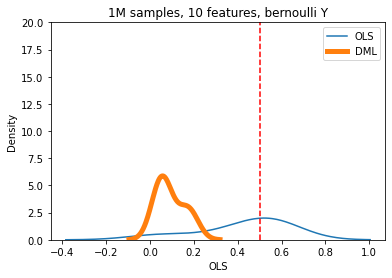

In [145]:
sns.kdeplot(df2.OLS, label = 'OLS')
sns.kdeplot(df2.DML, label = 'DML', linewidth='5')
plt.axvline(trt_effect, color = 'r', linestyle='--')
plt.ylim(0,20)
plt.legend()
plt.title("1M samples, 10 features, bernoulli Y")

In [1]:
plt.hist(Y)

NameError: name 'plt' is not defined

Next steps: Check out box cox transformations on target variable